In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler,
    OneHotEncoder, LabelEncoder, OrdinalEncoder,
    PolynomialFeatures
)
from sklearn.impute import SimpleImputer, KNNImputer

import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Data preparing and preprocessing

In [3]:
df = pd.read_csv('./data/Global_Development_Indicators_2000_2020.csv')

In [4]:
df.fillna(df.mean(numeric_only=True), inplace=True)

In [5]:
print(df.isna().sum())

year                                      0
country_code                              0
country_name                              0
region                                 1008
income_group                           1029
currency_unit                          1008
gdp_usd                                   0
population                                0
gdp_per_capita                            0
inflation_rate                            0
unemployment_rate                         0
fdi_pct_gdp                               0
co2_emissions_kt                          0
energy_use_per_capita                     0
renewable_energy_pct                      0
forest_area_pct                           0
electricity_access_pct                    0
life_expectancy                           0
child_mortality                           0
school_enrollment_secondary               0
health_expenditure_pct_gdp                0
hospital_beds_per_1000                    0
physicians_per_1000             

In [6]:
df = df.drop(columns=['region', 'income_group', 'currency_unit'])

In [7]:
print(df.isna().sum())

year                                   0
country_code                           0
country_name                           0
gdp_usd                                0
population                             0
gdp_per_capita                         0
inflation_rate                         0
unemployment_rate                      0
fdi_pct_gdp                            0
co2_emissions_kt                       0
energy_use_per_capita                  0
renewable_energy_pct                   0
forest_area_pct                        0
electricity_access_pct                 0
life_expectancy                        0
child_mortality                        0
school_enrollment_secondary            0
health_expenditure_pct_gdp             0
hospital_beds_per_1000                 0
physicians_per_1000                    0
internet_usage_pct                     0
mobile_subscriptions_per_100           0
calculated_gdp_per_capita              0
real_economic_growth_indicator         0
econ_opportunity

In [8]:
df_cleared = df.drop(columns=['years_since_2000', 'years_since_century', 'is_pandemic_period', 'human_development_composite', 'year', 'country_code', 'country_name', 'governance_quality_index', 'internet_usage_pct', 'mobile_subscriptions_per_100', 'education_health_ratio', 'global_development_resilience_index', 'co2_intensity_per_million_gdp'])

In [9]:
df_cleared.describe()

,gdp_usd,population,gdp_per_capita,inflation_rate,unemployment_rate,fdi_pct_gdp,co2_emissions_kt,energy_use_per_capita,renewable_energy_pct,forest_area_pct,...,green_transition_score,ecological_preservation_index,renewable_energy_efficiency,healthcare_capacity_index,digital_connectivity_index,health_development_ratio,human_development_index,climate_vulnerability_index,digital_readiness_score,global_resilience_score
count,5.556000e+03,5.556000e+03,5556.000000,5556.000000,5556.000000,5556.000000,5.556000e+03,5556.000000,5556.000000,5556.000000,...,5556.000000,5556.000000,5556.000000,5556.000000,5556.000000,5556.000000,5556.000000,5556.000000,5556.000000,5556.000000
mean,2.008355e+12,2.803412e+08,13795.817996,5.672921,7.931009,8.257269,1.121548e+06,2348.102738,30.136454,32.321885,...,30.136454,1.423242,6.451143,32.689495,4.028989,5.692028,0.655851,0.355641,0.370564,0.444183
std,7.145199e+12,8.833686e+08,21356.152812,15.885464,5.366190,54.873561,3.235446e+06,2029.383933,27.030396,22.835904,...,27.030396,1.592646,15.145880,67.500723,3.721305,6.334250,0.253182,0.098701,0.293003,0.260637
min,1.319654e+07,9.392000e+03,111.927225,-18.108630,0.100000,-1275.189986,0.000000e+00,9.548060,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.175371,-0.259046,0.046064,0.000000,-2.748146
25%,6.427532e+09,1.362497e+06,1523.496083,2.028945,4.479250,1.575230,4.875000e+03,1219.826064,7.038275,12.731705,...,7.038275,0.042510,0.934828,0.000000,0.385371,1.172355,0.507309,0.279549,0.094469,0.365905
50%,4.687279e+10,9.460952e+06,5071.950964,4.108692,7.016000,3.164215,6.348500e+04,2348.102738,27.649244,31.242095,...,27.649244,1.049848,6.451143,0.000000,3.151044,3.954014,0.655851,0.367475,0.332576,0.444183
75%,6.280724e+11,5.915911e+07,15383.866888,5.672921,9.509250,7.301829,1.121548e+06,2348.102738,43.762501,46.377833,...,43.762501,2.136633,6.451143,32.689495,7.317161,5.692028,0.870724,0.436504,0.617325,0.532583
max,8.756805e+13,7.761620e+09,189487.147128,557.201817,37.250000,1709.765678,3.404105e+07,22120.430302,98.342903,98.338910,...,98.342903,8.682123,580.855155,521.652851,17.010630,41.280488,1.171897,0.500000,1.570052,1.549244


In [10]:
X_reg = df_cleared.loc[:, df_cleared.columns != 'inflation_rate']
y_reg = df_cleared.loc[:, ['inflation_rate']]

In [11]:
from sklearn.model_selection import train_test_split
X_train_linreg, X_test_linreg, y_train_linreg, y_test_linreg = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)

# Multicolinearity check

In [12]:
constant_features = [col for col in X_reg.columns if X_reg[col].nunique() == 1]
print("Constant features:", constant_features)

Constant features: []


In [13]:
from statsmodels.tools.tools import add_constant

X_reg_check = X_reg

vif_df = pd.DataFrame()
vif_df["feature"] = X_reg_check.columns
vif_df["VIF"] = [variance_inflation_factor(X_reg_check.values, i) for i in range(X_reg_check.shape[1])]

In [14]:
vif_df

,feature,VIF
0,gdp_usd,3.531146e+00
1,population,3.981302e+00
2,gdp_per_capita,2.591562e+03
3,unemployment_rate,1.187858e+00
4,fdi_pct_gdp,1.131844e+00
5,co2_emissions_kt,5.352847e+00
6,energy_use_per_capita,2.274810e+00
7,renewable_energy_pct,1.671994e+11
8,forest_area_pct,4.111555e+00
9,electricity_access_pct,5.121818e+00


In [15]:
multicolineared_columns = ['internet_usage_pct', 'mobile_subscriptions_per_100', 'education_health_ratio', 'global_development_resilience_index', 'co2_intensity_per_million_gdp']

# Linear Regresion

In [16]:
model_linreg = sm.OLS(y_train_linreg, X_train_linreg).fit()
print(model_linreg.summary())

                            OLS Regression Results                            
Dep. Variable:         inflation_rate   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     4.186
Date:                Sun, 18 May 2025   Prob (F-statistic):           2.80e-12
Time:                        22:16:50   Log-Likelihood:                -16150.
No. Observations:                3889   AIC:                         3.236e+04
Df Residuals:                    3861   BIC:                         3.253e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
gdp_usd     

In [17]:
preds_new = model_linreg.predict(X_test_linreg)
print(preds_new)

4456     7.300157
4626     9.740071
2802     4.021171
230      6.912679
3872     5.747388
          ...    
3166     3.330062
5512     2.257291
1427     2.380475
3869     4.267966
5290    12.518856
Length: 1667, dtype: float64


In [18]:
r2 = model_linreg.rsquared
print('R^2:', r2)

R^2: 0.028438804428820075


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [20]:
mae = mean_absolute_error(y_test_linreg, preds_new)
mse = mean_squared_error(y_test_linreg, preds_new)
rmse = mean_squared_error(y_test_linreg, preds_new)
r2 = r2_score(y_test_linreg, preds_new)

print(f'RMSE: {rmse}')
print(f'R^2: {r2}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')

RMSE: 261.6237722008474
R^2: 0.038026047739232904
MAE: 4.1611325886124755
MSE: 261.6237722008474


# Logistic Regression

In [21]:
df_cleared_class = df.drop(columns=['years_since_2000', 'years_since_century', 'human_development_composite', 'year', 'country_code', 'country_name', 'governance_quality_index', 'internet_usage_pct', 'mobile_subscriptions_per_100', 'education_health_ratio', 'global_development_resilience_index', 'co2_intensity_per_million_gdp'])

In [22]:
X_class = df_cleared_class.loc[:, df_cleared_class.columns != 'is_pandemic_period']
y_class = df_cleared_class.loc[:, ['is_pandemic_period']]

In [23]:
X_train_logreg, X_test_logreg, y_train_logreg, y_test_logreg = train_test_split(X_class, y_class, test_size=0.3, random_state=42)

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss

## Logistic regression with LBFGS, L2 regulirization, tolerance 0.001, Regularization factor - 1/C = 0.05 

\begin{aligned}
& \text{Input: Initial guess } w_0, \text{ parameters } m \\
& \text{Initialize: } H_0 = I \text{ (identity matrix)}, s_0 = \text{undefined}, y_0 = \text{undefined} \\
& \text{For } k = 1, 2, \dots \text{ until convergence:} \\
& \quad 1. \text{Compute the gradient: } g_k = \nabla f(w_{k-1}) \\
& \quad 2. \text{Compute the search direction: } p_k = -H_{k-1} g_k \\
& \quad 3. \text{Perform a line search to find a step size } \alpha_k > 0 \text{ such that } f(w_{k-1} + \alpha_k p_k) \text{ is sufficiently decreased.} \\
& \quad 4. \text{Update the parameters: } w_k = w_{k-1} + \alpha_k p_k \\
& \quad 5. \text{Compute } s_{k-1} = w_k - w_{k-1} = \alpha_k p_k \\
& \quad 6. \text{Compute } y_{k-1} = g_k - g_{k-1} \\
& \quad 7. \text{Update the inverse Hessian approximation } H_k \text{ using the L-BFGS update rule based on } (s_{k-1}, y_{k-1}) \text{ and potentially the } m \text{ most recent pairs.} \\
& \quad \quad \text{The two-loop recursion for updating } H_k \text{ efficiently is often used here.} \\
& \text{Output: } w_k \text{ (the approximate minimizer)}
\end{aligned}

In [25]:
model_logit = LogisticRegression(penalty='l2', tol=1e-4, C=20, solver='lbfgs')
model_logit.fit(X_train_logreg, y_train_logreg)

probs = model_logit.predict_proba(X_test_logreg)[:, 1]
preds = model_logit.predict(X_test_logreg)

print('Accuracy:', accuracy_score(y_test_logreg, preds))
print('ROC AUC:', roc_auc_score(y_test_logreg, probs))
print('Log Loss:', log_loss(y_test_logreg, probs))

Accuracy: 0.9064187162567486
ROC AUC: 0.32045087327844884
Log Loss: 0.5444725878276483


/Users/Fattakh/Documents/GitHub/avalon-api/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Fattakh/Documents/GitHub/avalon-api/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Logistic regression with saga, elasticnet, tolerance 0.01, Regularization factor - 1/C = 0.05, l1_ration=0.7
Apparently in those kind of economical and high numerical dimension what really matters it is solver, how actually the gradient in built, is it counting all numerical features, or trying avoid some. We can actually see that Saga performing better than LBFGS, because of stochastic nature of SAGA and elasticnet regulirization factor. Moreover, SAGA saving information of previous step gradients, it is giving better performance of gradient how to understand the distribution and loss function antology. 
$$
\min_{w} \left[ f(w) = \frac{1}{n} \sum_{i=1}^{n} f_i(w) + \lambda R(w) \right]
$$

$$
w^{k+1} = w^k - \eta \left( \nabla f_j(w^k) - \alpha_j + \frac{1}{n} \sum_{i=1}^n \alpha_i + \lambda \nabla R(w^k) \right)
$$


In [26]:
model_logit = LogisticRegression(penalty='elasticnet', tol=1e-3, C=100, solver='saga', l1_ratio=0.7)
model_logit.fit(X_train_logreg, y_train_logreg)

probs = model_logit.predict_proba(X_test_logreg)[:, 1]
preds = model_logit.predict(X_test_logreg)

print('Accuracy:', accuracy_score(y_test_logreg, preds))
print('ROC AUC:', roc_auc_score(y_test_logreg, probs))
print('Log Loss:', log_loss(y_test_logreg, probs))

Accuracy: 0.9508098380323935
ROC AUC: 0.3973070708625067
Log Loss: 0.6220758948246078


/Users/Fattakh/Documents/GitHub/avalon-api/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [27]:
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_class, y_class, test_size=0.3, random_state=42)

# Decision Tree Classifier

In [28]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score

Best k: 5 with f1 score: 0.9781


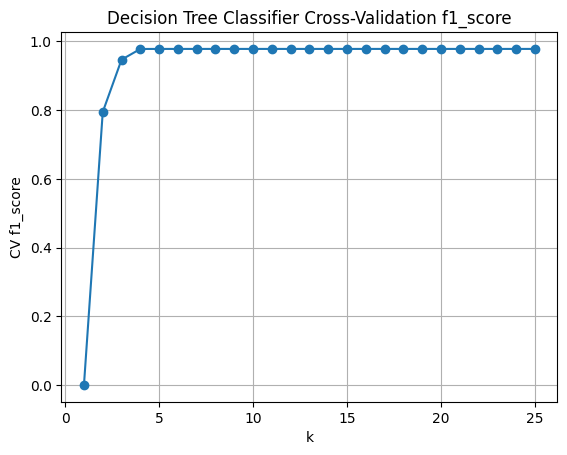

In [29]:
X_train_tree_clf = X_train_clf
y_train_tree_clf = np.ravel(y_train_clf)

from sklearn.model_selection import cross_val_score

cv_scores_decisionTree_clf = []

max_depth_range = range(1, 26)

for i in max_depth_range:
    tree_clf = DecisionTreeClassifier(max_depth=i, random_state=42, criterion='entropy')
    scores = cross_val_score(tree_clf, X_train_tree_clf, y_train_tree_clf, cv=5, scoring='f1')
    cv_scores_decisionTree_clf.append(scores.mean())
    i+=5

best_k = max_depth_range[np.argmax(cv_scores_decisionTree_clf)]
print(f'Best k: {best_k} with f1 score: {max(cv_scores_decisionTree_clf):.4f}')

plt.plot(max_depth_range, cv_scores_decisionTree_clf, marker='o')
plt.xlabel('k')
plt.ylabel('CV f1_score')
plt.title('Decision Tree Classifier Cross-Validation f1_score')
plt.grid(True)
plt.show()

# Decision Tree Regressor

Best k: 20 with d2_absolute_error score: 0.6507


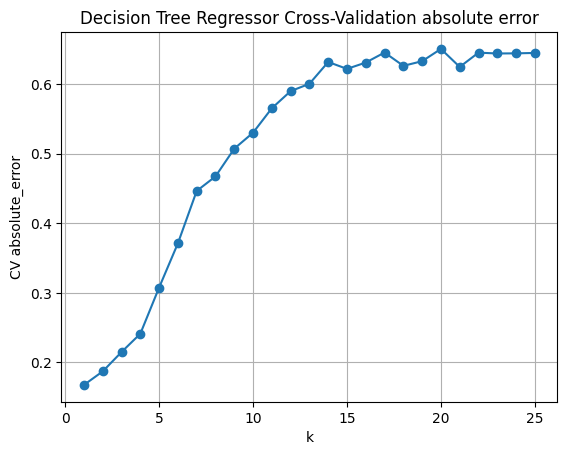

In [30]:
X_train_tree_reg = X_train_linreg
y_train_tree_reg = np.ravel(y_train_linreg)

from sklearn.model_selection import cross_val_score

cv_scores_decisionTree_reg = []

max_depth_range = range(1, 26)

for i in max_depth_range:
    tree_reg = DecisionTreeRegressor(max_depth=i, random_state=42, criterion='absolute_error')
    scores = cross_val_score(tree_reg, X_train_tree_reg, y_train_tree_reg, cv=5, scoring='d2_absolute_error_score')
    cv_scores_decisionTree_reg.append(scores.mean())
    i+=5

best_k = max_depth_range[np.argmax(cv_scores_decisionTree_reg)]
print(f'Best k: {best_k} with d2_absolute_error score: {max(cv_scores_decisionTree_reg):.4f}')

plt.plot(max_depth_range, cv_scores_decisionTree_reg, marker='o')
plt.xlabel('k')
plt.ylabel('CV absolute_error')
plt.title('Decision Tree Regressor Cross-Validation absolute error')
plt.grid(True)
plt.show()

# Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

y_train_clf = np.ravel(y_train_clf)

forest_clf = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42, criterion='entropy')
forest_clf.fit(X_train_clf, y_train_clf)
y_pred_forest_clf = forest_clf.predict(X_test_clf)

print('Accuracy:', accuracy_score(y_test_clf, y_pred_forest_clf) )

Accuracy: 0.9994001199760048


In [33]:
y_train_tree_reg = np.ravel(y_train_tree_reg)

reg = RandomForestRegressor(n_estimators=5, max_depth=5, random_state=42, criterion='absolute_error')
reg.fit(X_train_tree_reg, y_train_tree_reg)
y_pred_forest_reg = reg.predict(X_test_linreg)

print('MAE:', mean_absolute_error(y_test_linreg, y_pred_forest_reg))

MAE: 3.0555189593971828


# Naive Bayess Classifier

In [34]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder

X_NB = X_class
y_NB = np.ravel(y_class)

X_train_NB, X_test_NB, y_train_NB, y_test_NB = train_test_split(X_NB, y_NB, random_state=42, test_size=0.3)


NB = GaussianNB()
NB.fit(X_train_NB, y_train_NB)
y_pred_NB = NB.predict(X_test_NB)

print('Accuracy:', accuracy_score(y_test_NB, y_pred_NB))

Accuracy: 0.9070185962807439


## Results of Naive Bayes Classifier showing that still the dataset having really good composition and distribution, extremely predictable, cleared from colinearity, having thorough feature clearing, and numerical nature. Nevertheless, we can assume that this high numerical dependence giving such a low sensivity for events and probability distribution for this type of dataset. During the whole analysis we can mark up that high level of numerical nature of dataset giving outstanding results for region classifying and regression, but in a case of probability classifying it gives gradually lower results of Accuracy.

# kNN

Best k: 9 with accuracy: 0.9525


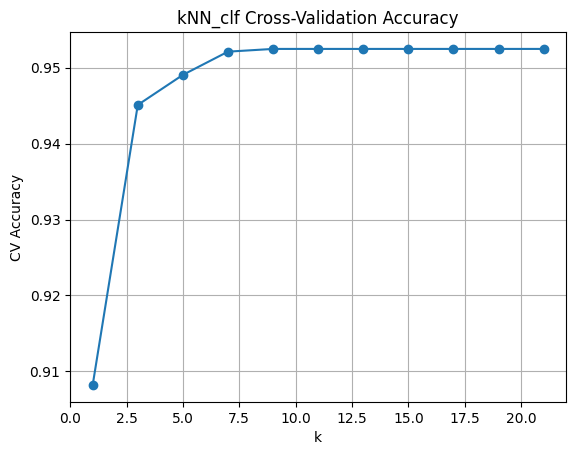

[np.float64(0.9082042556773663), np.float64(0.9451032513323275), np.float64(0.9490634854852391), np.float64(0.9521237915158421), np.float64(0.9524838275194425), np.float64(0.9524838275194425), np.float64(0.9524838275194425), np.float64(0.9524838275194425), np.float64(0.9524838275194425), np.float64(0.9524838275194425), np.float64(0.9524838275194425)]


In [35]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import cross_val_score

k_range = [i for i in range(1, 22) if i % 2 != 0]
cv_scores_knn_clf = []

X_knn_clf = X_class
y_knn_clf = np.ravel(y_class)


for k in k_range:
    kNN_clf = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
    scores = cross_val_score(kNN_clf, X_knn_clf, y_knn_clf, cv=5, scoring='accuracy')
    cv_scores_knn_clf.append(scores.mean())

best_k = k_range[np.argmax(cv_scores_knn_clf)]
print(f'Best k: {best_k} with accuracy: {max(cv_scores_knn_clf):.4f}')

plt.plot(k_range, cv_scores_knn_clf, marker='o')
plt.xlabel('k')
plt.ylabel('CV Accuracy')
plt.title('kNN_clf Cross-Validation Accuracy')
plt.grid(True)
plt.show()
print(cv_scores_knn_clf)

Best k (based on MAE): 19 with MAE: 4.8424


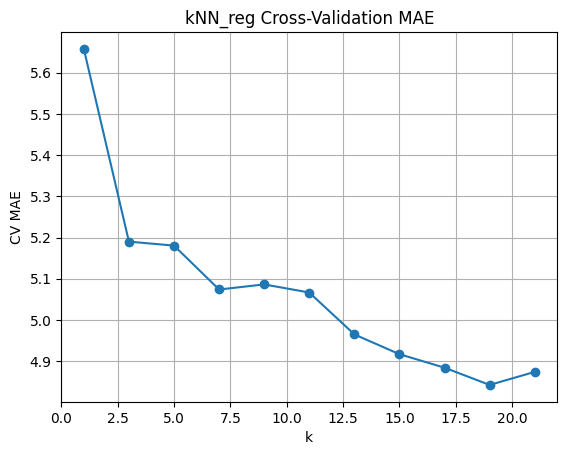

[np.float64(5.6576459750240655), np.float64(5.190054998433989), np.float64(5.1804115150760675), np.float64(5.0738978441802915), np.float64(5.086218528025711), np.float64(5.0665633329449085), np.float64(4.964934333956842), np.float64(4.916898182574987), np.float64(4.884159710279471), np.float64(4.842358534082274), np.float64(4.873966600024183)]


In [36]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

k_range = [i for i in range(1, 22) if i%2!=0]
cv_scores_knn_reg = []

X_knn_reg = X_reg
y_knn_reg = y_reg


for k in k_range:
    kNN_reg = KNeighborsRegressor(n_neighbors=k, metric='minkowski')
    scores = cross_val_score(kNN_reg, X_knn_reg, y_knn_reg, cv=5, scoring='neg_mean_absolute_error')
    cv_scores_knn_reg.append(scores.mean())

best_k_mae = k_range[np.argmax(cv_scores_knn_reg)]
best_neg_mae = max(cv_scores_knn_reg)
best_mae = -best_neg_mae 

print(f'Best k (based on MAE): {best_k_mae} with MAE: {best_mae:.4f}')

plt.plot(k_range, [-score for score in cv_scores_knn_reg], marker='o') # Plot the actual MAE values
plt.xlabel('k')
plt.ylabel('CV MAE')
plt.title('kNN_reg Cross-Validation MAE')
plt.grid(True)
plt.show()

cv_scores_knn_reg_cleared = [-score for score in cv_scores_knn_reg]
print(cv_scores_knn_reg_cleared)

# SVC

In [ ]:
from sklearn.svm import SVC

SVC = SVC()